In [1]:
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.callbacks import TensorBoard,Callback
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Conv2D,Input,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.python.keras.layers.merge import concatenate
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [40]:
# (128*128) 
# training
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

def data_generator(data_dir,mode,target_size=(128,512),batch_size=32,shuffle=True):
    
    for imgs in ImageDataGenerator().flow_from_directory(
    directory=data_dir,
    classes=[mode],
    class_mode=None,
    color_mode='rgb',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=shuffle
    ):
       
        y=imgs[:,0:128,128:256]/255
        x=np.zeros((y.shape[0],128,128,6))

        x[:,0:128,0:128,:3]=imgs[:,0:128,0:128]/255
        x[:,0:128,0:128,3:5]=imgs[:,0:128,256:384,:2]/255
        x[:,0:128,0:128,5]=imgs[:,0:128,384:512,0]/255
          
        yield x,y

        
BATCH_SIZE=32


# color+normal+depth
DATA_DIR='D:/Dataset/'
train_data_generator=data_generator(DATA_DIR,'training dataset',batch_size=BATCH_SIZE)


In [12]:
# (128*128) 
#testing
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

def data_generator(data_dir,mode,target_size=(128,512),batch_size=32,shuffle=True):
    
    for imgs in ImageDataGenerator().flow_from_directory(
    directory=data_dir,
    classes=[mode],
    class_mode=None,
    color_mode='rgb',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=shuffle
    ):
       
        y=imgs[:,0:128,128:256]/255
        x=np.zeros((y.shape[0],128,128,6))

        x[:,0:128,0:128,:3]=imgs[:,0:128,0:128]/255
        x[:,0:128,0:128,3:5]=imgs[:,0:128,256:384,:2]/255
        x[:,0:128,0:128,5]=imgs[:,0:128,384:512,0]/255
          
        yield x,y

        
BATCH_SIZE=32


# color+normal+depth
DATA_DIR='D:/Dataset/'
test_data_generator=data_generator(DATA_DIR,'testing data',batch_size=BATCH_SIZE)


In [31]:
tbCallBack = TensorBoard(log_dir='./logs', 
                 histogram_freq=0, 
                 batch_size=32,     
                 write_graph=True, 
                 write_grads=True, 
                 write_images=True,
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None,
                        )

In [25]:
cb=Callback()
# on_epoch_end='val_loss',verbose=1

In [2]:
from tensorflow.image import ssim
def ssim_fun(y_true,y_pred):
    s=ssim(y_true,y_pred,1)
    return s

def psnr(y_true,y_pred):
    return -10*K.log(
    K.mean(K.flatten((y_true-y_pred))**2)
    )/np.log(10)

inputs=Input((128,128,6),name='in')
conv1=Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',padding="same",name='conv1')(inputs)
pool1=MaxPooling2D((2,2),name='pool1')(conv1)

conv2=Conv2D(48,kernel_size=(3,3),strides=1,activation='relu',padding="same",name='conv2')(pool1)
pool2=MaxPooling2D((2,2),name='pool2')(conv2)

conv3=Conv2D(56,kernel_size=(3,3),strides=1,activation='relu',padding="same",name='conv3')(pool2)
pool3=MaxPooling2D((2,2),name='pool3')(conv3)


unpool2=concatenate([UpSampling2D(size=(2, 2))(pool3),pool2],name='unpool2')
# conv4=Conv2D(56,kernel_size=(3,3),strides=1,activation='relu',padding="same",name='conv4')(unpool2)
conv4=Conv2D(56,kernel_size=(3,3),strides=1,activation='relu',padding="same",name='conv5')(unpool2)

unpool1=concatenate([UpSampling2D(size=(2, 2))(conv4),pool1],name='unpool1')
# conv5=Conv2D(48,kernel_size=(3,3),strides=1,activation='relu',padding="same",name='conv6')(unpool1)
conv5=Conv2D(48,kernel_size=(3,3),strides=1,activation='relu',padding="same",name='conv7')(unpool1)

unpool0=concatenate([UpSampling2D(size=(2, 2))(conv5),inputs],name='inputs')
conv6=Conv2D(48,kernel_size=(3,3),strides=1,activation='relu',padding="same",name='conv8')(unpool0)
conv6=Conv2D(32,kernel_size=(3,3),strides=1,activation='relu',padding="same",name='conv9')(conv6)

conv7=Conv2D(3,kernel_size=(3,3),strides=1,activation='relu',padding="same",name='out')(conv6)


model=Model(inputs=inputs,outputs=conv7)
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[psnr,ssim_fun]
)


# model.fit(train_data_generator,steps_per_epoch=32,epochs=100,callbacks=[tbCallBack],shuffle=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in (InputLayer)                 (None, 128, 128, 6)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 32) 1760        in[0][0]                         
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 64, 64, 32)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 64, 48)   13872       pool1[0][0]                      
__________________________________________________________________________________________________
pool2 (Max

In [5]:
model.fit(train_data_generator,steps_per_epoch=32,epochs=2000,validation_split=0.1,callbacks=[tbCallBack],shuffle=True)

Epoch 1/2000
Found 25860 images belonging to 1 classes.
32/32 [==============================] - 26s 797ms/step - loss: 0.2629 - psnr: 22.9794 - ssim_fun: 0.5675
Epoch 2/2000
32/32 [==============================] - 24s 743ms/step - loss: 0.0507 - psnr: 28.2268 - ssim_fun: 0.7341
Epoch 3/2000
32/32 [==============================] - 24s 741ms/step - loss: 0.0348 - psnr: 29.7298 - ssim_fun: 0.7541
Epoch 4/2000
32/32 [==============================] - 24s 740ms/step - loss: 0.0280 - psnr: 30.6189 - ssim_fun: 0.7657
Epoch 5/2000
32/32 [==============================] - 23s 715ms/step - loss: 0.0263 - psnr: 30.9396 - ssim_fun: 0.7822
Epoch 6/2000
32/32 [==============================] - 23s 723ms/step - loss: 0.0219 - psnr: 31.7232 - ssim_fun: 0.7884
Epoch 7/2000
32/32 [==============================] - 23s 711ms/step - loss: 0.0213 - psnr: 31.8287 - ssim_fun: 0.8034
Epoch 8/2000
32/32 [==============================] - 23s 712ms/step - loss: 0.0198 - psnr: 32.1446 - ssim_fun: 0.8129
Epoch

32/32 [==============================] - 8s 248ms/step - loss: 0.0096 - psnr: 35.3494 - ssim_fun: 0.8974
Epoch 138/2000
32/32 [==============================] - 8s 248ms/step - loss: 0.0086 - psnr: 35.7716 - ssim_fun: 0.9025
Epoch 139/2000
32/32 [==============================] - 8s 257ms/step - loss: 0.0097 - psnr: 35.3147 - ssim_fun: 0.8974
Epoch 140/2000
32/32 [==============================] - 8s 248ms/step - loss: 0.0095 - psnr: 35.3880 - ssim_fun: 0.8999
Epoch 141/2000
32/32 [==============================] - 8s 257ms/step - loss: 0.0093 - psnr: 35.4521 - ssim_fun: 0.9016
Epoch 142/2000
32/32 [==============================] - 8s 255ms/step - loss: 0.0098 - psnr: 35.2405 - ssim_fun: 0.8965
Epoch 143/2000
32/32 [==============================] - 8s 256ms/step - loss: 0.0116 - psnr: 34.5373 - ssim_fun: 0.8954
Epoch 144/2000
32/32 [==============================] - 8s 254ms/step - loss: 0.0106 - psnr: 34.9148 - ssim_fun: 0.8940
Epoch 145/2000
32/32 [==============================] -

32/32 [==============================] - 8s 240ms/step - loss: 0.0100 - psnr: 35.2064 - ssim_fun: 0.8977
Epoch 274/2000
32/32 [==============================] - 8s 243ms/step - loss: 0.0091 - psnr: 35.5933 - ssim_fun: 0.9012
Epoch 275/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0083 - psnr: 35.9621 - ssim_fun: 0.9047
Epoch 276/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0086 - psnr: 35.8120 - ssim_fun: 0.9024
Epoch 277/2000
32/32 [==============================] - 8s 238ms/step - loss: 0.0080 - psnr: 36.1355 - ssim_fun: 0.9085
Epoch 278/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0082 - psnr: 36.0344 - ssim_fun: 0.9068
Epoch 279/2000
32/32 [==============================] - 7s 234ms/step - loss: 0.0090 - psnr: 35.4885 - ssim_fun: 0.9035
Epoch 280/2000
32/32 [==============================] - 7s 234ms/step - loss: 0.0085 - psnr: 35.8267 - ssim_fun: 0.9042
Epoch 281/2000
32/32 [==============================] -

32/32 [==============================] - 8s 240ms/step - loss: 0.0078 - psnr: 36.2024 - ssim_fun: 0.9100
Epoch 410/2000
32/32 [==============================] - 8s 238ms/step - loss: 0.0085 - psnr: 35.9086 - ssim_fun: 0.9069
Epoch 411/2000
32/32 [==============================] - 8s 239ms/step - loss: 0.0075 - psnr: 36.3884 - ssim_fun: 0.9127
Epoch 412/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0081 - psnr: 36.0592 - ssim_fun: 0.9073
Epoch 413/2000
32/32 [==============================] - 8s 238ms/step - loss: 0.0088 - psnr: 35.7294 - ssim_fun: 0.9046
Epoch 414/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0087 - psnr: 35.7596 - ssim_fun: 0.9070
Epoch 415/2000
32/32 [==============================] - 8s 243ms/step - loss: 0.0086 - psnr: 35.8664 - ssim_fun: 0.9078
Epoch 416/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0082 - psnr: 35.9988 - ssim_fun: 0.9088
Epoch 417/2000
32/32 [==============================] -

32/32 [==============================] - 8s 241ms/step - loss: 0.0073 - psnr: 36.4651 - ssim_fun: 0.9127
Epoch 546/2000
32/32 [==============================] - 8s 244ms/step - loss: 0.0077 - psnr: 36.2167 - ssim_fun: 0.9113
Epoch 547/2000
32/32 [==============================] - 8s 244ms/step - loss: 0.0076 - psnr: 36.2792 - ssim_fun: 0.9118
Epoch 548/2000
32/32 [==============================] - 8s 240ms/step - loss: 0.0080 - psnr: 36.1277 - ssim_fun: 0.9101
Epoch 549/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0075 - psnr: 36.3648 - ssim_fun: 0.9134
Epoch 550/2000
32/32 [==============================] - 8s 239ms/step - loss: 0.0082 - psnr: 36.0145 - ssim_fun: 0.9075
Epoch 551/2000
32/32 [==============================] - 8s 238ms/step - loss: 0.0080 - psnr: 36.1204 - ssim_fun: 0.9114
Epoch 552/2000
32/32 [==============================] - 8s 243ms/step - loss: 0.0073 - psnr: 36.4793 - ssim_fun: 0.9124
Epoch 553/2000
32/32 [==============================] -

32/32 [==============================] - 8s 240ms/step - loss: 0.0078 - psnr: 36.2428 - ssim_fun: 0.9108
Epoch 682/2000
32/32 [==============================] - 8s 243ms/step - loss: 0.0077 - psnr: 36.3033 - ssim_fun: 0.9130
Epoch 683/2000
32/32 [==============================] - 8s 236ms/step - loss: 0.0072 - psnr: 36.4525 - ssim_fun: 0.9136
Epoch 684/2000
32/32 [==============================] - 8s 239ms/step - loss: 0.0076 - psnr: 36.3384 - ssim_fun: 0.9115
Epoch 685/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0075 - psnr: 36.3984 - ssim_fun: 0.9130
Epoch 686/2000
32/32 [==============================] - 8s 240ms/step - loss: 0.0086 - psnr: 35.8162 - ssim_fun: 0.9079
Epoch 687/2000
32/32 [==============================] - 8s 244ms/step - loss: 0.0080 - psnr: 36.1032 - ssim_fun: 0.9119
Epoch 688/2000
32/32 [==============================] - 8s 240ms/step - loss: 0.0069 - psnr: 36.7330 - ssim_fun: 0.9150
Epoch 689/2000
32/32 [==============================] -

32/32 [==============================] - 8s 237ms/step - loss: 0.0070 - psnr: 36.6464 - ssim_fun: 0.9152
Epoch 818/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0075 - psnr: 36.4090 - ssim_fun: 0.9126
Epoch 819/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0072 - psnr: 36.5336 - ssim_fun: 0.9143
Epoch 820/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0080 - psnr: 36.1713 - ssim_fun: 0.9140
Epoch 821/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0097 - psnr: 35.3397 - ssim_fun: 0.9072
Epoch 822/2000
32/32 [==============================] - 8s 243ms/step - loss: 0.0084 - psnr: 35.8842 - ssim_fun: 0.9096
Epoch 823/2000
32/32 [==============================] - 8s 243ms/step - loss: 0.0090 - psnr: 35.6357 - ssim_fun: 0.9090
Epoch 824/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0083 - psnr: 36.0053 - ssim_fun: 0.9113
Epoch 825/2000
32/32 [==============================] -

32/32 [==============================] - 8s 242ms/step - loss: 0.0070 - psnr: 36.6685 - ssim_fun: 0.9152
Epoch 954/2000
32/32 [==============================] - 8s 243ms/step - loss: 0.0078 - psnr: 36.2036 - ssim_fun: 0.9132
Epoch 955/2000
32/32 [==============================] - 8s 244ms/step - loss: 0.0076 - psnr: 36.3523 - ssim_fun: 0.9117
Epoch 956/2000
32/32 [==============================] - 8s 243ms/step - loss: 0.0072 - psnr: 36.5140 - ssim_fun: 0.9147
Epoch 957/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0070 - psnr: 36.6820 - ssim_fun: 0.9165
Epoch 958/2000
32/32 [==============================] - 8s 243ms/step - loss: 0.0076 - psnr: 36.3193 - ssim_fun: 0.9133
Epoch 959/2000
32/32 [==============================] - 8s 244ms/step - loss: 0.0080 - psnr: 36.1321 - ssim_fun: 0.9108
Epoch 960/2000
32/32 [==============================] - 8s 244ms/step - loss: 0.0078 - psnr: 36.1997 - ssim_fun: 0.9114
Epoch 961/2000
32/32 [==============================] -

32/32 [==============================] - 7s 231ms/step - loss: 0.0067 - psnr: 36.7743 - ssim_fun: 0.9164
Epoch 1089/2000
32/32 [==============================] - 8s 234ms/step - loss: 0.0072 - psnr: 36.5720 - ssim_fun: 0.9137
Epoch 1090/2000
32/32 [==============================] - 8s 240ms/step - loss: 0.0074 - psnr: 36.4456 - ssim_fun: 0.9151
Epoch 1091/2000
32/32 [==============================] - 8s 238ms/step - loss: 0.0080 - psnr: 36.1346 - ssim_fun: 0.9120
Epoch 1092/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0070 - psnr: 36.6630 - ssim_fun: 0.9164
Epoch 1093/2000
32/32 [==============================] - 8s 239ms/step - loss: 0.0076 - psnr: 36.3252 - ssim_fun: 0.9148
Epoch 1094/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0077 - psnr: 36.2857 - ssim_fun: 0.9120
Epoch 1095/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0070 - psnr: 36.6629 - ssim_fun: 0.9156
Epoch 1096/2000
32/32 [=========================

32/32 [==============================] - 8s 240ms/step - loss: 0.0071 - psnr: 36.6133 - ssim_fun: 0.9147
Epoch 1223/2000
32/32 [==============================] - 8s 238ms/step - loss: 0.0071 - psnr: 36.6527 - ssim_fun: 0.9159
Epoch 1224/2000
32/32 [==============================] - 8s 240ms/step - loss: 0.0077 - psnr: 36.2470 - ssim_fun: 0.9131
Epoch 1225/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0069 - psnr: 36.7280 - ssim_fun: 0.9174
Epoch 1226/2000
32/32 [==============================] - 8s 244ms/step - loss: 0.0072 - psnr: 36.5533 - ssim_fun: 0.9148
Epoch 1227/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0070 - psnr: 36.7119 - ssim_fun: 0.9177
Epoch 1228/2000
32/32 [==============================] - 8s 239ms/step - loss: 0.0078 - psnr: 36.3096 - ssim_fun: 0.9147
Epoch 1229/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0070 - psnr: 36.6230 - ssim_fun: 0.9148
Epoch 1230/2000
32/32 [=========================

32/32 [==============================] - 8s 244ms/step - loss: 0.0071 - psnr: 36.6128 - ssim_fun: 0.9160
Epoch 1357/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0067 - psnr: 36.8032 - ssim_fun: 0.9179
Epoch 1358/2000
32/32 [==============================] - 8s 245ms/step - loss: 0.0076 - psnr: 36.3964 - ssim_fun: 0.9145
Epoch 1359/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0085 - psnr: 35.8766 - ssim_fun: 0.9093
Epoch 1360/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0075 - psnr: 36.3827 - ssim_fun: 0.9129
Epoch 1361/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0077 - psnr: 36.3298 - ssim_fun: 0.9163
Epoch 1362/2000
32/32 [==============================] - 8s 254ms/step - loss: 0.0080 - psnr: 36.1325 - ssim_fun: 0.9123
Epoch 1363/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0072 - psnr: 36.5822 - ssim_fun: 0.9145
Epoch 1364/2000
32/32 [=========================

32/32 [==============================] - 8s 242ms/step - loss: 0.0071 - psnr: 36.6161 - ssim_fun: 0.9161
Epoch 1491/2000
32/32 [==============================] - 8s 239ms/step - loss: 0.0072 - psnr: 36.6515 - ssim_fun: 0.9153
Epoch 1492/2000
32/32 [==============================] - 8s 234ms/step - loss: 0.0068 - psnr: 36.6703 - ssim_fun: 0.9184
Epoch 1493/2000
32/32 [==============================] - 8s 238ms/step - loss: 0.0068 - psnr: 36.7568 - ssim_fun: 0.9191
Epoch 1494/2000
32/32 [==============================] - 8s 238ms/step - loss: 0.0076 - psnr: 36.3814 - ssim_fun: 0.9154
Epoch 1495/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0073 - psnr: 36.5059 - ssim_fun: 0.9157
Epoch 1496/2000
32/32 [==============================] - 8s 243ms/step - loss: 0.0075 - psnr: 36.4102 - ssim_fun: 0.9141
Epoch 1497/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0070 - psnr: 36.6179 - ssim_fun: 0.9156
Epoch 1498/2000
32/32 [=========================

32/32 [==============================] - 8s 241ms/step - loss: 0.0071 - psnr: 36.6038 - ssim_fun: 0.9175
Epoch 1625/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0077 - psnr: 36.2738 - ssim_fun: 0.9122
Epoch 1626/2000
32/32 [==============================] - 8s 243ms/step - loss: 0.0071 - psnr: 36.6289 - ssim_fun: 0.9150
Epoch 1627/2000
32/32 [==============================] - 8s 244ms/step - loss: 0.0076 - psnr: 36.3701 - ssim_fun: 0.9152
Epoch 1628/2000
32/32 [==============================] - 8s 239ms/step - loss: 0.0077 - psnr: 36.3555 - ssim_fun: 0.9179
Epoch 1629/2000
32/32 [==============================] - 8s 241ms/step - loss: 0.0075 - psnr: 36.4003 - ssim_fun: 0.9140
Epoch 1630/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0075 - psnr: 36.3714 - ssim_fun: 0.9140
Epoch 1631/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0070 - psnr: 36.6745 - ssim_fun: 0.9152
Epoch 1632/2000
32/32 [=========================

32/32 [==============================] - 8s 242ms/step - loss: 0.0067 - psnr: 36.8551 - ssim_fun: 0.9184
Epoch 1759/2000
32/32 [==============================] - 8s 240ms/step - loss: 0.0072 - psnr: 36.6376 - ssim_fun: 0.9161
Epoch 1760/2000
32/32 [==============================] - 8s 240ms/step - loss: 0.0071 - psnr: 36.6215 - ssim_fun: 0.9183
Epoch 1761/2000
32/32 [==============================] - 8s 243ms/step - loss: 0.0076 - psnr: 36.3983 - ssim_fun: 0.9153
Epoch 1762/2000
32/32 [==============================] - 8s 242ms/step - loss: 0.0072 - psnr: 36.5716 - ssim_fun: 0.9178
Epoch 1763/2000
32/32 [==============================] - 8s 240ms/step - loss: 0.0079 - psnr: 36.2245 - ssim_fun: 0.9154
Epoch 1764/2000
32/32 [==============================] - 8s 245ms/step - loss: 0.0073 - psnr: 36.4988 - ssim_fun: 0.9161
Epoch 1765/2000
32/32 [==============================] - 8s 243ms/step - loss: 0.0067 - psnr: 36.8383 - ssim_fun: 0.9168
Epoch 1766/2000
32/32 [=========================

32/32 [==============================] - 8s 243ms/step - loss: 0.0071 - psnr: 36.5993 - ssim_fun: 0.9158
Epoch 1893/2000
32/32 [==============================] - 8s 240ms/step - loss: 0.0068 - psnr: 36.7669 - ssim_fun: 0.9180
Epoch 1894/2000
32/32 [==============================] - 8s 240ms/step - loss: 0.0073 - psnr: 36.5374 - ssim_fun: 0.9160
Epoch 1895/2000
32/32 [==============================] - 8s 244ms/step - loss: 0.0077 - psnr: 36.3386 - ssim_fun: 0.9151
Epoch 1896/2000
32/32 [==============================] - 8s 248ms/step - loss: 0.0074 - psnr: 36.4758 - ssim_fun: 0.9158
Epoch 1897/2000
32/32 [==============================] - 8s 236ms/step - loss: 0.0078 - psnr: 36.0767 - ssim_fun: 0.9130
Epoch 1898/2000
32/32 [==============================] - 8s 236ms/step - loss: 0.0069 - psnr: 36.7035 - ssim_fun: 0.9150
Epoch 1899/2000
32/32 [==============================] - 8s 239ms/step - loss: 0.0071 - psnr: 36.6311 - ssim_fun: 0.9155
Epoch 1900/2000
32/32 [=========================

Epoch 2001/2001
Found 25860 images belonging to 1 classes.
32/32 [==============================] - 539s 17s/step - loss: 0.0087 - psnr: 35.7863 - ssim_fun: 0.9079 - val_loss: 0.0131 - val_psnr: 33.8987 - val_ssim_fun: 0.8724


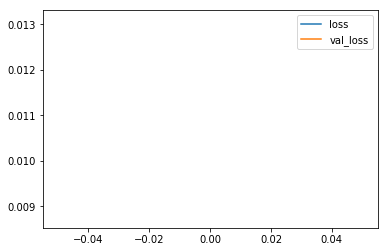

In [41]:
train_history=model.fit(train_data_generator,steps_per_epoch=32,initial_epoch=2000,epochs=2001,validation_data=validate_data_generator,validation_steps=2586,callbacks=[cb],shuffle=True)
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

In [13]:
test_history=model.evaluate(test_data_generator,verbose=1,batch_size=32,steps=109)

Found 3480 images belonging to 1 classes.
109/109 [==============================] - 21s 194ms/step


In [14]:
test_history

[0.01604481774928241, 33.017302537238464, 0.8688476892723435]

In [42]:
cb.params

{'batch_size': None,
 'epochs': 2001,
 'steps': 32,
 'samples': None,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss',
  'psnr',
  'ssim_fun',
  'val_loss',
  'val_psnr',
  'val_ssim_fun'],
 'validation_steps': 2586}

In [7]:
model.save('./20190714/model_2000.h5')

In [3]:
from tensorflow.image import ssim
def ssim_fun(y_pred,y_true):
    s=ssim(y_true,y_pred,1.0)
    return s

def psnr(y_pred,y_true):
    return -10*K.log(
    K.mean(K.flatten((y_true-y_pred))**2)
    )/np.log(10)

# def mean_squared_error(y_true, y_pred):
#     return  K.mean(K.square(y_pred - y_true), axis=-1)

model = tf.contrib.keras.models.load_model('./20190717/model_2000.h5',custom_objects={"psnr":psnr,"ssim_fun":ssim_fun})


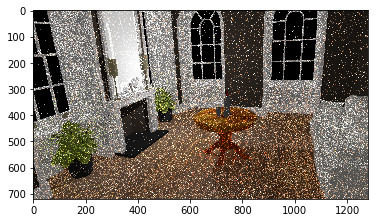

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


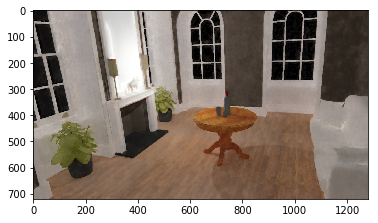

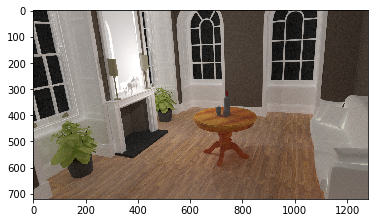

1/1 [==============================] - 0s 110ms/step
loss function: 0.0015305798733606935
PSNR:  28.151437759399414
SSIM:  0.7416440844535828


In [15]:

    
#     testing data path
# path_t='C:/Users/NTNU_CGLab/Documents/denoisy/TestData/sponza/point light/1sppImage_20190606.ppm'
# path_n='C:/Users/NTNU_CGLab/Documents/denoisy/TestData/sponza/point light/1sppImage_Normal_20190606.ppm'
# path_d='C:/Users/NTNU_CGLab/Documents/denoisy/TestData/sponza/point light/1sppImage_Depth_20190606.ppm'

path_t='C:/Users/NTNU_CGLab/Documents/denoisy/TestData/hairball/1sppImage_hairball.ppm'
path_n='C:/Users/NTNU_CGLab/Documents/denoisy/TestData/hairball/1sppImage_Normal_hairball.ppm'
path_d='C:/Users/NTNU_CGLab/Documents/denoisy/TestData/hairball/1sppImage_Depth_hairball.ppm'

# # #     testing data path
# # fireplace
path_t='./20190626/test/1sppImage2.ppm'
path_n='./20190626/test/1sppImage_Normal2.ppm'
path_d='./20190626/test/1sppImage_Depth2.ppm'

# # # path_c='./20190623/test2/1sppImage_Color.ppm'
# # # path_l='./20190623/test2/1sppImage_Distance.ppm'

# #     testing data path
# bath
# path_t='./20190629/test2/optixPathTracernoise_1.ppm'
# path_n='./20190629/test2/optixPathTracer_Normal1.ppm'
# path_d='./20190629/test2/optixPathTracer_Depth1.ppm'

#     testing data path
# car
# path_t='./20190629/test3/optixPathTracernoise_1.ppm'
# path_n='./20190629/test3/optixPathTracer_Normal1.ppm'
# path_d='./20190629/test3/optixPathTracer_Depth1.ppm'

# #     testing data path
# path_t='./20190629/test/1sppImage.ppm'
# path_n='./20190629/test/1sppImage_Normal.ppm'
# path_d='./20190629/test/1sppImage_Depth.ppm'

# #     testing data path
# path_t='./testdata/test11/1sppImage.ppm'
# path_n='./testdata/test11/1sppImage_Normal.ppm'
# path_d='./testdata/test11/1sppImage_Depth.ppm'

# # #     testing data path
# path_t='./testdata/other scene/2/1sppImage.ppm'
# path_n='./testdata/other scene/2/1sppImage_Normal.ppm'
# path_d='./testdata/other scene/2/1sppImage_Depth.ppm'

# trace depth
# # #     testing data path  光線沒有設定追蹤深度
# path_t='./testdata/depth None/1sppImage.ppm'
# path_n='./testdata/depth None/1sppImage_Normal.ppm'
# path_d='./testdata/depth None/1sppImage_Depth.ppm'


# #     testing data path
# san
# path_d='C:/Users/NTNU_CGLab/Documents/denoisy/TestData/gallery/4/1sppImage_Depth_gallery.ppm'
# path_n='C:/Users/NTNU_CGLab/Documents/denoisy/TestData/gallery/4/1sppImage_Normal_gallery.ppm'
# path_t='C:/Users/NTNU_CGLab/Documents/denoisy/TestData/gallery/4/1sppImage_gallery.ppm'

h=720
w=1280
x=np.zeros((1,h,w,6))

#     get noise
img_x=cv2.imread(path_t)
img_x=img_x[:,:,::-1]
x[0,:,:,:3]=img_x[:h,:w,:]

#     get normal
img_n=cv2.imread(path_n)
img_n=img_n[:,:,::-1]
x[0,:,:,3:5]=img_n[:h,:w,:2]

#     get depth
img_d=cv2.imread(path_d)
img_d=img_d[:,:,::-1]
x[0,:,:,5]=img_d[:h,:w,0]



# #     get material color
# img_c=cv2.imread(path_c)
# img_c=img_c[:,:,::-1]
# x[0,:,:,6:]=img_c

# #     get light to  hitpoint
# img_l=cv2.imread(path_l)
# img_l=img_l[:,:,::-1]
# x[0,:,:,6]=img_l[:,:,0]


prds_img=model.predict(x/255) 
plt.imshow(img_x/255)
plt.show()
plt.imshow(prds_img[0])
plt.show()



for i in range(prds_img[0].shape[0]):
    for k in range(prds_img[0].shape[1]):
        r,g,b=prds_img[0,i,k]
        if r>1:
            r=1
        if g>1:
            g=1
        if b>1:
            b=1    
        prds_img[0,i,k]=r,g,b

# plt.imsave("./20190717/bath_2000", prds_img[0])  

# path2='C:/Users/NTNU_CGLab/Documents/denoisy/TestData/hairball/64sppImage_hairball.ppm'

# # ground truth
path2='./20190626/test/400sppImage2.ppm'

# path2='./20190629/test2/optixPathTracer1.ppm'

# path2='./20190629/test/400sppImage.ppm'

# path2='./testdata/test11/400sppImage.ppm'
# path2='./testdata/other scene/2/400sppImage.ppm'

# trace path
# path2='./testdata/depth None/400sppImage.ppm'

# path2='C:/Users/NTNU_CGLab/Documents/denoisy/TestData/gallery/4/400sppImage_gallery.ppm'
# 
img2 = cv2.imread(path2)
img2 = img2[:,:,::-1]
test_y=np.array((img2[:h,:w,:]))
test_y=test_y[np.newaxis,:]
test_y=test_y[:,:h,:w,:]
plt.imshow(test_y[0]/255)
# plt.imsave("./20190708/sponza1_1800_ground truth", test_y[0]/255) 
plt.show()

loss_function,psnr_val,ssim_val=model.evaluate(x/255.0,test_y/255.0)
print("loss function:",loss_function)
print("PSNR: ",psnr_val)
print("SSIM: ",ssim_val)



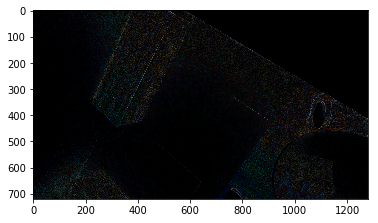

In [14]:
a=np.zeros((1,720,1280,3))
for h in range(720):
    for w in range(1280):
        r,g,b=prds_img[0,h,w]
#         *255
        r1,g1,b1=test_y[0,h,w]/255
        r=abs(r-r1)
        g=abs(g-g1)
        b=abs(b-b1)
        a[0,h,w]=r*2,g*2,b*2


plt.imshow(a[0])
plt.show()  
plt.imsave("./20190717/bath_diffence", a[0])  

In [ ]:
path2='./20190626/test/400sppImage2.ppm'

path2='./20190629/test2/optixPathTracer1.ppm'

path2='./20190629/test/400sppImage.ppm'

# path2='./testdata/test11/400sppImage.ppm'
# path2='./testdata/other scene/2/400sppImage.ppm'

# trace path
# path2='./testdata/depth None/400sppImage.ppm'
path2='C:/Users/NTNU_CGLab/Documents/denoisy/TestData/gallery/4/400sppImage_gallery.ppm'

# img2 = cv2.imread(path2)
# img2 = img2[:,:,::-1]
# test_y=np.array((img2[:720,:1280,:]))
# test_y=test_y[np.newaxis,:]
# plt.imshow(test_y[0]/255)
# plt.show()

path_t='./20190626/sponza1_2000_n.png'

img3 = cv2.imread(path_t)
img3 = img3[:,:,::-1]
noise=np.array((img3[:,:,:]))
noise=noise[np.newaxis,:]
plt.imshow(noise[0]/255)
plt.show()

In [6]:

y_regression=test_y[0].astype(np.float32).reshape((-1,1))
preds=prds_img[0].astype(np.float32).reshape((-1,1))
# preds=noise.astype(np.float32).reshape((-1,1))/255


mse=np.mean(np.square((y_regression/255.0 - preds)))
print('mse=%5f' % np.mean(np.square((y_regression/255.0 - preds))))
psnr_val= -10*np.log(np.mean(mse))/np.log(10)
print('psnr=%2f' % psnr_val)


# print('manual result: mse=%5f' % np.mean(np.square((y_regression/255.0 - noisey/255.0))))

mse=0.001274
psnr=28.946910


In [7]:
with tf.Session() as sess:
    im1 = tf.image.convert_image_dtype(test_y[0]/255, tf.float32)
    im2 = tf.image.convert_image_dtype(prds_img[0], tf.float32)
#     im3 = tf.image.convert_image_dtype(noise[0]/255, tf.float32)
    ssim2 = ssim_fun(im1, im2)
#     ssim3 = ssim_fun(im1, im3)
    print(ssim2.eval())
#     print(ssim3.eval())

0.8005633


In [53]:
-10*np.log(
np.mean(0.0007774)
)/np.log(10)

31.093554637047518

In [59]:
from tensorflow.image import ssim
def ssim_fun(y_pred,y_true):
    s=ssim(y_true,y_pred,1.0)
    return s

def psnr(y_pred,y_true):
    return -10*K.log(
    K.mean(K.flatten((y_true-y_pred))**2)
    )/np.log(10)

# def mean_squared_error(y_true, y_pred):
#     return  K.mean(K.square(y_pred - y_true), axis=-1)

model = tf.contrib.keras.models.load_model('./20190513/1/model_ssim_100.h5',custom_objects={"psnr":psnr,"ssim_fun":ssim_fun})


In [47]:
# (128*128) 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

def data_generator(data_dir,mode,target_size=(128,512),batch_size=32,shuffle=True):
    
    for imgs in ImageDataGenerator().flow_from_directory(
    directory=data_dir,
    classes=[mode],
    class_mode=None,
    color_mode='rgb',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=shuffle
    ):
       
        y=imgs[:,0:128,128:256]/255
        x=np.zeros((y.shape[0],128,128,6))

        x[:,0:128,0:128,:3]=imgs[:,0:128,0:128]/255
        x[:,0:128,0:128,3:5]=imgs[:,0:128,256:384,:2]/255
        x[:,0:128,0:128,5]=imgs[:,0:128,384:512,0]/255
          
        yield x,y

        
BATCH_SIZE=32


# color+normal+depth
DATA_DIR='D:/Dataset/testing dataset/'
validate_data_generator=data_generator(DATA_DIR,'sponza3',batch_size=BATCH_SIZE)


In [15]:
def stats_graph(graph):
    flops = tf.profiler.profile(graph, options=tf.profiler.ProfileOptionBuilder.float_operation())
    params = tf.profiler.profile(graph, options=tf.profiler.ProfileOptionBuilder.trainable_variables_parameter())
    print('FLOPs: {};    Trainable params: {}'.format(flops.total_float_ops, params.total_parameters))
    
sess = K.get_session()
graph = sess.graph
stats_graph(graph)

96 ops no flops stats due to incomplete shapes.
96 ops no flops stats due to incomplete shapes.


FLOPs: 2678111417;    Trainable params: 505566


In [99]:
def inputdata(i):
    path_t='./testdata/sponza3_720x1280/sponza3c/optixPathTracernoise_'+repr(i)+'.ppm'
    path_n='./testdata/sponza3_720x1280/sponza3n/optixPathTracer'+repr(i)+'.ppm'
    path_d='./testdata/sponza3_720x1280/sponza3d/optixPathTracer'+repr(i)+'.ppm'
    x=np.zeros((1,720,1280,6))
    
    #     get noise
    img_x=cv2.imread(path_t)
    img_x=img_x[:,:,::-1]
    x[0,:,:,:3]=img_x[:h,:w,:]

    #     get normal
    img_n=cv2.imread(path_n)
    img_n=img_n[:,:,::-1]
    x[0,:,:,3:5]=img_n[:h,:w,:2]

    #     get depth
    img_d=cv2.imread(path_d)
    img_d=img_d[:,:,::-1]
    x[0,:,:,5]=img_d[:h,:w,0]
    
    path_f='./testdata/sponza3_720x1280/sponza3/optixPathTracer'+repr(i+1)+'.ppm'

    img3 = cv2.imread(path_f)
    img3 = img3[:,:,::-1]
    test_y=np.array((img3[:,:,:]))
    test_y=test_y[np.newaxis,:]
    
    return x/255,test_y/255



In [101]:
# find testing datas which psnr<30
file_name=[]
loss_function=[]
psnr_val=[]
ssim_val=[]
from glob import glob
file=glob('D:/Dataset/testing dataset/sponza3/*.[pP][nN][gG]')
print(len(file))

# for i in file:
for i in range(101):   
#     imgs=cv2.imread(i)
#     imgs=imgs[:,:,::-1]
#     y=np.zeros((1,128,128,3))
#     x=np.zeros((1,128,128,6))
#     y[0]=imgs[0:128,128:256,:]


#     x[0,0:128,0:128,:3]=imgs[0:128,0:128]
#     x[0,0:128,0:128,3:5]=imgs[0:128,256:384,:2]
#     x[0,0:128,0:128,5]=imgs[0:128,384:512,0]

    h=720
    w=1280
    x=np.zeros((1,h,w,6))
    x,y=inputdata(i)
#     y=y/255
#     x=x/255

    l,p,s=model.evaluate(x,y,verbose=0)
    loss_function.append(l)
    psnr_val.append(p)
    ssim_val.append(s)
    
    if p<30:
        file_name.append(i)


6060


In [105]:
np.mean(loss_function)

0.0004301829705024046

In [ ]:
loss_function,psnr_val,ssim_val=model.evaluate(train_data_generator,steps=6000, verbose=1)
# tol_loss_function+=loss_function
# tol_psnr_val+=psnr_val
# tol_ssim_val+=ssim_val
print("loss function:",loss_function)
print("PSNR: ",psnr_val)
print("SSIM: ",ssim_val)

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 101)     2828      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 101)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 76)        69160     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 76)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 57)        39045     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 57)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        16448     
__________

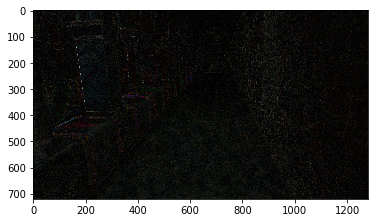

In [58]:
a=np.zeros((1,720,1280,3))
for h in range(720):
    for w in range(1280):
        r,g,b=prds_img[0,h,w]
#         *255
        r1,g1,b1=test_y[0,h,w]/255
        r=abs(r-r1)
        g=abs(g-g1)
        b=abs(b-b1)
        a[0,h,w]=r*2,g*2,b*2


plt.imshow(a[0])
plt.show()  
plt.imsave("./20190714/sponza11_diffence", a[0])  